In [6]:
import optuna
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2 as transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, Compose

from hyperparams_explore import hp_categorical
from models import ResNet18, DenseNet121, PreActResNet18
from transforms import cutout, gaussian_noise, hide_and_seek
from utils import (
    DEFAULT_TRANSFORMS,
    get_device,
    get_optimiser,
    get_scheduler,
    get_hyperparams,
    get_cifar10_train_val_loaders,
    test,
    train,
)

In [3]:
trial_res = {
    "params": {'userotation': False, 'usetranslation': False, 'useshearing': True, 'usehorizontal_flip': True, 'usevertical_flip': False, 'usecrop': False, 'usecolor_jitter': False, 'usenoise_injection': False, 'usekernel': False, 'userandom_erasing': False, 'usecutout': False, 'usehide_and_seek': False},
    "value": 87.58,
}
from utils import pickle_dump

pickle_dump(trial_res, "transforms_best_trial")

In [ ]:
"""Trial 13 finished with value: 87.58 and parameters: {'userotation': False, 'usetranslation': False, 'useshearing': True, 'usehorizontal_flip': True, 'usevertical_flip': False, 'usecrop': False, 'usecolor_jitter': False, 'usenoise_injection': False, 'usekernel': False, 'userandom_erasing': False, 'usecutout': False, 'usehide_and_seek': False}. Best is trial 13 with value: 87.58."""

" Trial 13 finished with value: 87.58 and parameters: {'userotation': False, 'usetranslation': False, 'useshearing': True, 'usehorizontal_flip': True, 'usevertical_flip': False, 'usecrop': False, 'usecolor_jitter': False, 'usenoise_injection': False, 'usekernel': False, 'userandom_erasing': False, 'usecutout': False, 'usehide_and_seek': False}. Best is trial 13 with value: 87.58."

In [8]:
rotation_degree = 45
translation = (0.2, 0.2) 
shearing = (10, 20, 0, 10)  # horizontal shear: 10–20°, vertical shear: 0–10°
kernel_size = 5
CUTOUT_SIZE = 16
CUTOUT_PROB = 1

transformations = {
    # Geometric
    "rotation": transforms.RandomRotation(rotation_degree),
    "translation": transforms.RandomAffine(degrees=0, translate=translation),
    "shearing": transforms.RandomAffine(degrees=0, shear=shearing),

    # Non geometric
    "horizontal_flip": transforms.RandomHorizontalFlip(),
    "vertical_flip": transforms.RandomVerticalFlip(),
    "crop": transforms.RandomCrop(32, padding=4),
    "color_jitter": transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    "noise_injection": gaussian_noise,
    "kernel": transforms.GaussianBlur(kernel_size=kernel_size),

    # Erasing
    "random_erasing": transforms.RandomErasing(),
    "cutout": cutout(mask_size=CUTOUT_SIZE, p=CUTOUT_PROB),
    "hide_and_seek": hide_and_seek,
    
}

In [12]:
from torchvision.datasets import CIFAR10
from utils import ROOT_DIR
import numpy as np

dataset = CIFAR10(root=ROOT_DIR, train=True, download=True, transform=None)

image, label = dataset[0]  # image is already a PIL.Image.Image


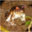

In [ ]:
image = .copy()

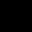

In [ ]:
hide_and_seek(transforms.ToImage()(image))

In [20]:
n_epochs = 1
hp_params = get_hyperparams()
chosen_model = DenseNet121

study = optuna.create_study(direction="maximize") 
study.optimize(
    lambda x: objective(x, chosen_model, hp_params, n_epochs),
    n_trials=10,
)

# Print the best hyperparameters
print(f"Best trial: {study.best_trial.params}")

[I 2025-04-23 21:40:17,866] A new study created in memory with name: no-name-8d958b48-9e0e-4b19-ba42-fe262e8d759e
[W 2025-04-23 21:40:30,520] Trial 0 failed with parameters: {'userotation': True, 'usetranslation': True, 'useshearing': True, 'usehorizontal_flip': False, 'usevertical_flip': True, 'usecrop': False, 'usecolor_jitter': True, 'usenoise_injection': True, 'usekernel': True, 'userandom_erasing': False, 'usecutout': False, 'usehide_and_seek': False} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/users/local/b24richa/EDL/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_3642248/3170120209.py", line 7, in <lambda>
    lambda x: objective(x, chosen_model, hp_params, n_epochs),
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3642248/2718117664.py", line 46, in objective
 

KeyboardInterrupt: 

In [2]:
best

{'userotation': True,
 'usetranslation': False,
 'useshearing': False,
 'usehorizontal_flip': False,
 'usevertical_flip': False,
 'usecrop': False,
 'usecolor_jitter': False,
 'usekernel': False,
 'userandom_erasing': False}

In [7]:

import torch.nn as nn
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, Compose

from hyperparams_explore import hp_categorical
from models import DenseNet121
from utils import (
    DEFAULT_TRANSFORMS,
    get_cifar10_train_val_loaders,
    get_device, get_hyperparams,
    get_optimiser, get_scheduler,
    pickle_dump,
    test,
    train,
)


if __name__ == "__main__":

    n_epochs = 20
    hp_params = get_hyperparams()
    chosen_model = DenseNet121

    autoaugment_transform = Compose([
        AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
        *DEFAULT_TRANSFORMS,
    ])
    train_loader, val_loader = get_cifar10_train_val_loaders(transform=autoaugment_transform)

    model = chosen_model()
    device = get_device()
    model.to(device)
    
    optimiser = get_optimiser(
        hp_params["optimizer"],
        model.parameters(),
        lr=hp_params["lr"],
        weight_decay=hp_params["weight_decay"]
    )
    s_name = hp_params["lr_scheduler"]
    scheduler = get_scheduler(
        s_name,
        optimiser,
        **hp_categorical["lr_schedulers"]["params"][s_name]
    )
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0
    for epoch in range(n_epochs):
        train_acc, train_loss = train(train_loader, model, optimiser, criterion, device)
        val_acc, val_loss = test(val_loader, model, criterion, device)

        if s_name == "ReduceLROnPlateau":
            scheduler.step(val_loss)
        else:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc


    auto_augment_acc = {"autoaugment_acc": best_val_acc}
    pickle_dump(auto_augment_acc, "autoaugment_acc")

    print("RUN SUCESS AUGO AUGMENT")

KeyboardInterrupt: 

In [5]:
for i, t in train_loader:
    break

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>